# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Angel Racini Meza
## C.C 1017248189


## Importanto Librerias

In [65]:
import pandas as pd
import numpy as np 
import os
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import MinMaxScaler
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
%matplotlib inline

## Preprocesando los datos

In [114]:
#Extrayendo los archivos de la carpeta precios
path  = r'datos\precios'
datos = os.listdir(path)
Consolidado = pd.DataFrame(columns = ['Fecha', "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",                                          "13", "14","15", "16", "17", "18", "19", "20", "21", "22", "23"])

for archivo in datos:
    df = pd.read_excel(path+"\\"+archivo)
    df  = df.iloc[:,0:25]
    df = df.dropna()       
    df.rename(columns=df.iloc[0], inplace = True)
    df = df.drop(df.index[0])
    df.reset_index(drop=True, inplace=True)
    df.columns = ['Fecha', "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14",                             "15", "16", "17", "18", "19", "20", "21", "22", "23"]
    Consolidado = pd.concat([Consolidado, df])

#IMPRIMIENDO LOS PRIMEROS 5 REGISTROS DEL ARCHIVO CONSOLIDADO
Consolidado.head(5)

,Fecha,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1995-07-21,1.073,1.000,1.000,1.00,1.00,1.000,5.000,6.000,6.000,...,5.000,1.000,1.000,5.000,12.000,16.670,11.929,5.000,1.000,1.000
1,1995-07-22,1.073,1.073,1.000,1.00,1.00,1.073,1.303,1.303,1.303,...,1.073,1.000,1.000,1.000,1.303,2.500,2.500,1.303,1.073,1.073
2,1995-07-23,1.073,1.000,1.000,1.00,1.00,1.000,0.100,1.000,1.000,...,1.000,0.100,0.100,1.000,1.238,1.238,1.238,1.238,1.073,1.000
3,1995-07-24,1,1.000,0.990,1.00,1.00,1.073,3.000,3.000,3.000,...,1.073,1.073,3.000,2.000,18.630,22.500,9.256,3.000,1.073,1.000
4,1995-07-25,0.99,0.990,0.989,0.99,0.99,1.073,1.263,1.263,1.263,...,1.073,1.073,1.073,1.073,1.263,1.500,1.263,1.263,1.073,0.990


**Ajustando los precios historicos al valor actual del peso dado por el IPC.**

In [115]:
#Obteniendo el promedio para cada dia
Precios_Promedio = Consolidado.set_index('Fecha')
Precios_Promedio['Precio_Promedio'] = Precios_Promedio.sum(axis = 1) / 24.0
Precios_Promedio = Precios_Promedio.loc[:,'Precio_Promedio']
Precios_Promedio = Precios_Promedio.reset_index()

#Leyendolos datos del banco de la republica
IPC = pd.read_excel(r"C:\Users\ANGEL\Desktop\Trabajo Redes Neuronales\evaluacion-arracinim\1.2.5.IPC_Serie_variaciones.xlsx", header = 12)
IPC = IPC.iloc[:,0:2] 
IPC = IPC.iloc[:-6] #No nos interesa las ultima 6 columnas correspondientes a los creditos
IPC.columns = ['Date_Month', 'IPC']

#Convierto las fechas a formato YYYY-MM

IPC['Date_Month'] = IPC['Date_Month'].astype(str)
IPC['Date_Month'] = IPC['Date_Month'].apply(lambda x: x[:4] + '-' + x[4:])
IPC['Date_Month'] = pd.to_datetime(IPC['Date_Month']).dt.to_period('M')
Precios_Promedio['Date_Month'] = pd.to_datetime(Precios_Promedio['Fecha']).dt.to_period('M')


#Haciendo un merge para calcular los nuevos precios
Precios = pd.merge(Precios_Promedio, IPC[["Date_Month", "IPC"]], on="Date_Month", how="left")

#Recalculando el valor del peso al valor actual segun el IPC para cada fila
IPC_ACTUAL = IPC.tail(1).iloc[0,1]
Precios['Precio_Promedio_Ajustado'] =  Precios['Precio_Promedio'] * (IPC_ACTUAL / Precios['IPC'])
Precios.head(5)

,Fecha,Precio_Promedio,Date_Month,IPC,Precio_Promedio_Ajustado
0,1995-07-21,4.924333,1995-07,20.93,24.689897
1,1995-07-22,1.269500,1995-07,20.93,6.365090
2,1995-07-23,0.953083,1995-07,20.93,4.778622
3,1995-07-24,4.305917,1995-07,20.93,21.589245
4,1995-07-25,1.149167,1995-07,20.93,5.761756


In [116]:
#Conviertiendo las fechas a formato datetime
Precios = Precios.loc[:,['Fecha', 'Precio_Promedio_Ajustado']]
Precios_Full_Date = Precios.loc[:,['Fecha', 'Precio_Promedio_Ajustado']]
Precios_Full_Date['Fecha'] = pd.to_datetime(Precios_Full_Date['Fecha'], format='%Y-%m-%d')

#Diviendo las fechas en Año, mes y dia. (Expansión de fechas)
Precios['Fecha'] = pd.to_datetime(Precios['Fecha'], format='%Y-%m-%d')
Precios['Año'] = Precios['Fecha'].dt.year
Precios['Mes'] = Precios['Fecha'].dt.month
Precios['Dia'] = Precios['Fecha'].dt.day
Precios = Precios.loc[:,['Año', "Mes", "Dia", 'Precio_Promedio_Ajustado']]
Precios.head()

,Año,Mes,Dia,Precio_Promedio_Ajustado
0,1995,7,21,24.689897
1,1995,7,22,6.365090
2,1995,7,23,4.778622
3,1995,7,24,21.589245
4,1995,7,25,5.761756


## Transformando los datos

<Figure size 1440x576 with 0 Axes>

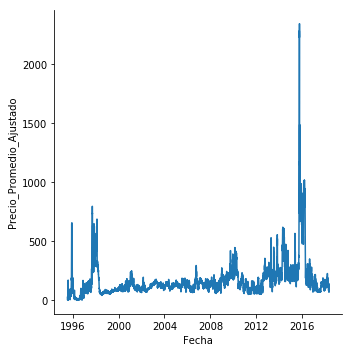

In [117]:
#Observando el comportamiento del precio en el tiempo
plt.figure(figsize=(20, 8))
sns.relplot(x="Fecha", y="Precio_Promedio_Ajustado",
            kind="line", data= Precios_Full_Date)

Podemos observar en la grafica que hay datos muy desfazados sobretodo entre los años 1996-2000 y los años 2015-2017
esto anterior puede significar valores atípicos o valores no atipicos que requerirá una transformacion a los datos de salida (target), además se puede notar que hay mucho ruido lo que indica problemas de heterosedasticidad.

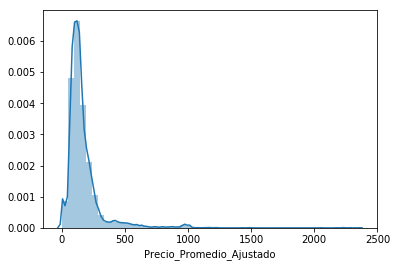

In [118]:
#Verificando si los datos cumplen en supuesto de normalidad por observación grafica. 
sns.distplot(Precios_Full_Date.loc[:,'Precio_Promedio_Ajustado'])

In [12]:
#Precios['Precio_Promedio_Ajustado'] = np.log(Precios['Precio_Promedio_Ajustado'])

## Implementando el ADALINE


Se implementa un ADALINE para regresion con GD (Gradiente descendente) y momentum  

In [120]:
class Adaline():

    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 momentum=0.9,      # Momentum               
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   
                 warm_start=False):   

        self.momentum = momentum
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n) 
                X = X[n,:] 
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_ 
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:] + self.coef_ * self.momentum
                self.intercept_ += 2 * self.learning_rate * e + self.intercept_*self.momentum
                errors2.append(e**2)
                forecasts.append(u)

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

### ENTRENANDO EL MODELO 

En este caso tomaremos para entrenamiento todos los datos, exceptuando los ultimos 7 dias, con los cuales se hará el pronostico.

**Hayando la cantidad de retardos, el momentum y learning rate optimos**

In [197]:
train = Precios.head(len(Precios)-7)
test = Precios.tail(7)
test = test.reset_index(drop=True)

Escalamos la entrada

In [198]:
x_train = train.iloc[:,:3]
y_train = train.iloc[:,-1]
x_test = test.iloc[:,:3] 
y_test = test.iloc[:,-1]

In [199]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

Buscando el mejor modelo con respecto a los hiperparametros

In [200]:
momentums = np.arange(0.00000, 0.0001,0.000025)
learning_rates = np.arange(0.005, 0.1, 0.005)
dic_list = []

for i in momentums:
    for j in learning_rates:
        m = Adaline(
        learning_rate=j, 
        momentum = i,  
        shuffle=False,       
        random_state=201,
        max_epochs=1,
        warm_start=False)    
        m.fit(x_test,y_test)
        mse = mean_squared_error(y_test, m.predict(x_test))
        dic_list.append({"momentum": j, "learning_rate":i, "MSE":mse})
            
    
scores = pd.DataFrame(data = dic_list)

Seleccionamos el **Learning rate** y el **momentum** que disminuye el error para un **retardo** de 7.

In [201]:
scores = scores[scores['MSE'] == scores['MSE'].min()]
scores

,MSE,learning_rate,momentum
37,114.214386,0.000025,0.095


En este caso el mejor modelo con el MSE mas bajo es aquel con un **learning_rate** de 0.000025 y un **momentum** de 0.095

**Implementando el modelo y generando el pronostico para 7 dias**

In [202]:
m = Adaline(
learning_rate=0.000025, 
momentum = 0.095,  
shuffle=False,       
random_state=201,
max_epochs=1,
warm_start=False)

In [227]:
m.fit(x_test,y_test)
y_pred = (m.predict(x_test)) 